# Create a own graph with retrieve as tool.Also using private and open LLM


## Set up

In [2]:
from dotenv import load_dotenv, find_dotenv
import os
import warnings
from IPython.display import display, Markdown  # to see better the output text

warnings.filterwarnings("ignore")
_ = load_dotenv(find_dotenv())  # read local .env file

os.environ["LANGCHAIN_TRACING_V2"] = "true"


In [3]:
# ! pip install langchain_openai
# ! pip install langchain_ollama
from langchain_ollama.chat_models import ChatOllama
from langchain_openai import ChatOpenAI

gpt_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

gemma_llm = ChatOllama(
    model="gemma2:latest",
    temperature=0.1,
)

In [133]:
SYSTEM_MESSAGE = "You are a helpful assistant. Answer the questions using the information retrieved"
NUM_RETRIEVAL_CHUNKS = 3
NUM_HISTORY_MESSAGES = 6

## Store the documents to simulate the Vector DB

In [24]:
from langchain_ollama import OllamaEmbeddings
from typing_extensions import List, TypedDict
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_community.document_loaders import WebBaseLoader
from langchain import hub
import bs4
from langchain_core.vectorstores import InMemoryVectorStore

embeddings = OllamaEmbeddings(model="mxbai-embed-large")
vector_store = InMemoryVectorStore(embeddings)

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Build the retrieve process as a tool

In [49]:
from langchain_core.tools import StructuredTool
from langchain_core.tools import tool
from pydantic import BaseModel, Field


# @tool(response_format="content_and_artifact")


class RetieveSchema(BaseModel):
    query: str = Field(description="query to execute")


def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(
        query, k=NUM_RETRIEVAL_CHUNKS)
    content = "\n\n".join(
        # it's important to keep the metadata to know the source of the retrieved content
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return content


retrieve_tool = StructuredTool(description="Retrieve information related to a query.",
                               name="retrieve_tool", func=retrieve, args_schema=RetieveSchema)

In [55]:
Markdown(retrieve_tool.invoke("what is the Task Decomposition?"))

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)
The system comprises of 4 stages:
(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to guide LLM to do task parsing and planning.
Instruction:

## Create the graph

In [149]:
from typing import Annotated
from langgraph.graph import MessagesState, StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict): # it's the same to use `MessagesState` 
    """Define the state schema for the workflow in the graph."""
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

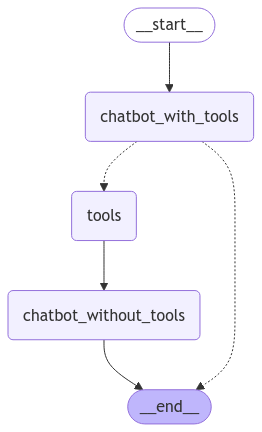

In [150]:
from IPython.display import Image
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import SystemMessage, trim_messages


tools = [retrieve_tool]
llm_with_tools = gpt_llm.bind_tools(tools)

trimmer = trim_messages(
    max_tokens=NUM_HISTORY_MESSAGES,  # in this case we want to keep the last 5 messages
    strategy="last",
    token_counter=len,
    include_system=True,
    start_on="human",
    end_on=("human", "tool"),
)


def chatbot_with_tools(state: State):
    if state["messages"][0].type != "system":
        state["messages"].insert(0, SystemMessage(content=SYSTEM_MESSAGE))

    trimmed_messages = trimmer.invoke(state["messages"])

    return {"messages": [llm_with_tools.invoke(trimmed_messages)]}

def chatbot_without_tools(state: State):
    
    trimmed_messages = trimmer.invoke(state["messages"])

    return {"messages": [gemma_llm.invoke(trimmed_messages)]}



graph_builder.add_node("chatbot_with_tools", chatbot_with_tools)
graph_builder.add_node("chatbot_without_tools", chatbot_without_tools)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot_with_tools",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot_without_tools")
graph_builder.add_edge("chatbot_without_tools",END)
graph_builder.add_edge(START, "chatbot_with_tools")


memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

Image(graph.get_graph().draw_mermaid_png())

In [151]:
config = {"configurable": {"thread_id": "1"}}
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [152]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", "what is the Task Decomposition?" )]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is the Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve_tool (call_L30ubdPjNHWcOG1H9fBOPY9H)
 Call ID: call_L30ubdPjNHWcOG1H9fBOPY9H
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve_tool

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. Co

In [153]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", "what is my name and my age?" )]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name and my age?
================================== Ai Message ==================================
Tool Calls:
  retrieve_tool (call_zwiEKY7qzokcBXBSBl6jeCfC)
 Call ID: call_zwiEKY7qzokcBXBSBl6jeCfC
  Args:
    query: user name and age
================================= Tool Message =================================
Name: retrieve_tool

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Conversatin samples:
[
  {
    "role": "system",

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Here are a sample conversation for task clarification sent to OpenAI ChatCompletion endpoint used by GPT-Engineer. The user inputs are wrapped in {{user input text}}.
[
  {
    "role": "system",
    "content": "You will read instructions and not carry them out, only seek to clarify them.\nSpecifically you will first summarise a list of super short bu

### Gemma answer without the context 

In [154]:
Markdown(gemma_llm.invoke("what is the Task Decomposition?").content)


Task decomposition is a technique used in artificial intelligence (AI) and software engineering to break down complex tasks into smaller, more manageable subtasks. 

Here's a breakdown:

**Why decompose tasks?**

* **Simplicity:**  Large tasks can be overwhelming. Breaking them down makes them easier to understand, plan, and execute.
* **Modularity:** Subtasks can be developed and tested independently, allowing for parallel development and faster progress.
* **Reusability:** Well-defined subtasks can be reused in different contexts or projects, saving time and effort.
* **Scalability:**  Decomposition allows systems to handle increasingly complex tasks by adding more subtasks as needed.

**How is it done?**

There are various methods for decomposing tasks:

* **Hierarchical Decomposition:** Breaking down a task into a tree-like structure with parent and child subtasks.
* **Functional Decomposition:** Identifying the distinct functions required to complete the task and assigning each function to a separate subtask.
* **Data Flow Decomposition:** Analyzing the flow of data through the task and defining subtasks based on data transformations or processing steps.

**Example:**

Imagine you want to build a system that recommends movies to users. 

* **Decomposition:** You could break this down into subtasks like:
    * **Data Collection:** Gather user ratings, movie information, and genre data.
    * **Data Preprocessing:** Clean and format the collected data.
    * **Recommendation Algorithm:** Develop an algorithm to generate movie recommendations based on user preferences.
    * **User Interface:** Create a user-friendly interface for displaying recommendations.

Each subtask can then be further decomposed into smaller steps, making the overall project more manageable.


**Tools and Techniques:**

Various tools and techniques aid in task decomposition:

* **UML Diagrams:**  Visualize the relationships between tasks and subtasks.
* **Flowcharts:** Illustrate the sequential flow of operations within a task.
* **Requirement Analysis:** Clearly define the goals and functionalities of each subtask.



Let me know if you'd like to explore any specific aspect of task decomposition in more detail!

### Gemma answer with the context

In [170]:
history = graph.get_state(config).values["messages"]
Markdown(history[6].content)

Task decomposition is a problem-solving technique where you break down a large, complex task into smaller, more manageable subtasks. 

Think of it like building a house: instead of trying to build the entire structure at once, you'd start with laying the foundation, then walls, then the roof, and so on. Each step is a smaller task that contributes to the overall goal of completing the house.

**Here are some benefits of task decomposition:**

* **Makes complex tasks less overwhelming:**  Breaking things down into smaller chunks makes them feel more achievable.
* **Improves focus:** By concentrating on one subtask at a time, you can give it your full attention and avoid getting bogged down.
* **Easier to plan and schedule:** You can allocate time and resources more effectively when you know exactly what needs to be done and in what order.
* **Identifies dependencies:**  Decomposition helps reveal which tasks rely on others being completed first, allowing for better sequencing.
* **Facilitates collaboration:** Smaller tasks are easier to assign to different individuals or teams, promoting efficient teamwork.


Let me know if you'd like to explore any of these points further or have a specific task in mind that you'd like to decompose!

### Compare to GPT-4o-mini answer with the same context than Gemma

In [171]:

history[:6]

[SystemMessage(content='You are a helpful assistant. Answer the questions using the information retrieved', additional_kwargs={}, response_metadata={}, id='8f1fac5f-9d1e-4185-8d68-e7d463ff764d'),
 HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='4d622f42-7c20-437a-a787-0e5e8c915c5e'),
 AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 71, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-3e86abee-ce9a-4d28-9f02-73d1f498912b-0', usage_metadata={'input_tokens': 71, 'output_tokens': 12, 'total_tokens': 83, 'input_to

In [172]:

Markdown(gpt_llm.invoke(history[:6]).content)


Task decomposition is a process used to break down complex tasks into smaller, more manageable steps. This technique is particularly useful in various fields, including artificial intelligence and project management. 

In the context of AI, particularly with large language models (LLMs), task decomposition can enhance performance on complex tasks by prompting the model to "think step by step." This method, known as Chain of Thought (CoT), allows the model to transform a big task into multiple simpler tasks, making it easier to tackle each component systematically.

There are several ways to perform task decomposition:

1. **Simple Prompting**: Asking the model to outline the steps needed to achieve a goal (e.g., "Steps for XYZ.\n1.") or to identify subgoals (e.g., "What are the subgoals for achieving XYZ?").
   
2. **Task-Specific Instructions**: Providing specific instructions tailored to the task at hand (e.g., "Write a story outline." for writing a novel).

3. **Human Inputs**: Involving human guidance to help break down the tasks.

Additionally, more advanced methods like the Tree of Thoughts extend the CoT approach by exploring multiple reasoning possibilities at each step, creating a tree structure of thoughts that can be evaluated through various search processes.

Overall, task decomposition is a valuable strategy for managing complexity and improving clarity in problem-solving.

### Another fast test

I am asking about the importance of task decomposition, but the message history contains relevant information. So, it's not necessary making another retrieval.


In [158]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", "So, you think that the Task Decomposition is no-important en AI" )]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

So, you think that the Task Decomposition is no-important en AI
================================== Ai Message ==================================

Task decomposition is actually very important in AI. It helps break down complex tasks into smaller, manageable parts, making it easier for the AI to understand and execute them effectively. This approach can lead to better organization, improved performance, and more accurate results. 

In many applications, including programming, project management, and problem-solving, decomposing tasks allows for clearer planning and execution. Would you like to know more about how task decomposition is applied in AI?


### Another fast test

Now, I am asking about chatbots, So It's necessary making another retrieval.


In [159]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", "What is the role of that in intelligent chatbots?" )]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the role of that in intelligent chatbots?
================================== Ai Message ==================================

Task decomposition plays a crucial role in the functioning of intelligent chatbots in several ways:

1. **Understanding User Intent**: By breaking down user queries into smaller components, chatbots can better understand the intent behind a user's message. This helps in accurately interpreting what the user is asking for.

2. **Managing Conversations**: Chatbots can decompose conversations into distinct topics or tasks, allowing them to manage multi-turn dialogues more effectively. This ensures that the chatbot can keep track of the context and flow of the conversation.

3. **Response Generation**: When generating responses, chatbots can decompose the information needed into smaller parts, allowing them to construct more relevant and coherent replies based on the user's input

In [160]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", "What is an intelligent chatbots?" )]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is an intelligent chatbots?
================================== Ai Message ==================================

Intelligent chatbots are advanced software applications designed to simulate human-like conversations with users through text or voice interactions. They leverage artificial intelligence (AI), natural language processing (NLP), and machine learning to understand, interpret, and respond to user queries in a way that feels natural and engaging. Here are some key characteristics of intelligent chatbots:

1. **Natural Language Understanding (NLU)**: They can comprehend and process human language, allowing them to understand user intents and extract relevant information from queries.

2. **Context Awareness**: Intelligent chatbots can maintain context over multiple interactions, enabling them to provide more relevant responses based on previous exchanges.

3. **Learning Capabilities**: Many intell

In [161]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", "What is the utility of agents for LLM?" )]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the utility of agents for LLM?
================================== Ai Message ==================================
Tool Calls:
  retrieve_tool (call_Mp01YuOEjyDHL3Et7hMO1IPB)
 Call ID: call_Mp01YuOEjyDHL3Et7hMO1IPB
  Args:
    query: utility of agents for LLM
================================= Tool Message =================================
Name: retrieve_tool

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: }
]
Challenges#
After going through key ideas and demos of building LLM-centered agents, I start to see a couple common limitations:

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as Au

In [162]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", "can you tell me about the Tools Use?" )]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me about the Tools Use?
================================== Ai Message ==================================
Tool Calls:
  retrieve_tool (call_HMF75yOk8G8iZ5RWRz80Qg3h)
 Call ID: call_HMF75yOk8G8iZ5RWRz80Qg3h
  Args:
    query: Tools Use in LLM agents
================================= Tool Message =================================
Name: retrieve_tool

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: }
]
Challenges#
After going through key ideas and demos of building LLM-centered agents, I start to see a couple common limitations:

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGP